In [11]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
image_path = '../images/C39_7.5UP.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

(1024, 1280, 3)


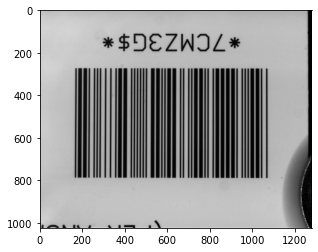

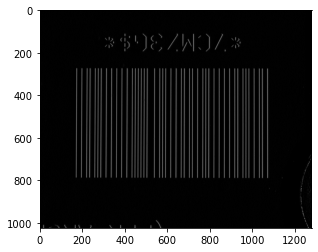

In [3]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

# Find contours
kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
image_horizontal_derivative = np.abs(image_horizontal_derivative)
kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
image_vertical_derivative = np.abs(image_vertical_derivative)

image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

plt.figure()
plt.imshow(image_horizontal_derivative, 'gray')

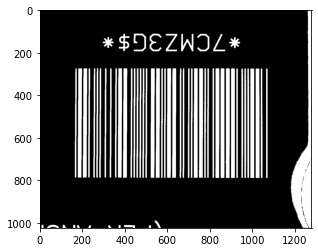

In [5]:
# Threshold, Otsu's algorithm
#ret2,thresh = cv2.threshold(image_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh = 255 - thresh

plt.figure()
plt.imshow(thresh, 'gray')

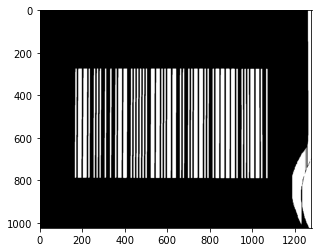

In [6]:
# Keep only vertical bars
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')

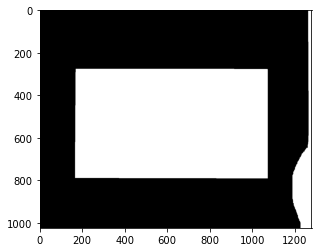

In [7]:
# OPTION A: closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')

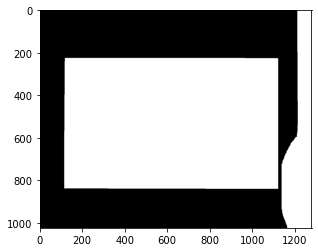

In [8]:
# Option B : dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))

dilated = cv2.dilate(opened, None, iterations = 50)

plt.figure()
plt.imshow(dilated, 'gray')

In [9]:
def apply_dilation(opened):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))

    dilated = cv2.dilate(opened, None, iterations = 1)
    
    while True:
        cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #print(cnts)
        cnts = imutils.grab_contours(cnts)
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        # compute the rotated bounding box of the largest contour
        rect = cv2.minAreaRect(c)
        box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
        box = np.int0(box)
        #print(box)
        
        dilated_bb = dilated.copy() 
        cv2.cvtColor(dilated_bb, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(dilated_bb, [box], -1, (0,0,255), 3)
        plt.figure()
        plt.imshow(dilated_bb)
        
        box = sorted(sorted([tuple(coords) for coords in box]))
        #print(box)
        
        sub_dilated = dilated[box[0][1]:box[1][1], box[0][0]:box[2][0]]
        #print(sub_dilated.shape)
        
        foreground_dilated = dilated.sum()
        foreground_dilated_sub = sub_dilated.sum()
        print(foreground_dilated)
        print(foreground_dilated_sub)
        
        if foreground_dilated_sub/foreground_dilated>0.9:
            break
            
        dilated = cv2.dilate(dilated, None, iterations = 1)
        
    return dilated
        

85477275
9765990
98095440
9917460
110753130
12517695
118661445
16763955
122622360
17064855
126597810
17431800
130591365
17767380
134604300
18105000
138060315
125106825


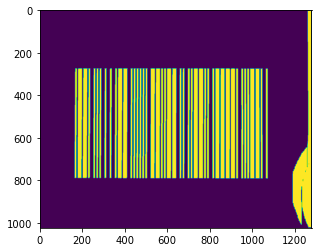

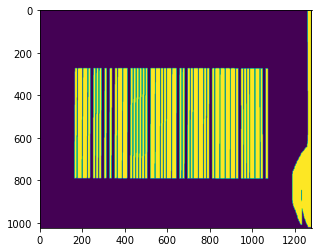

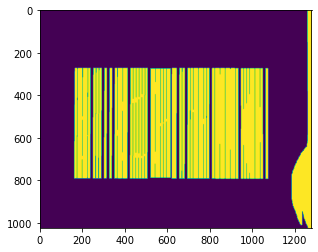

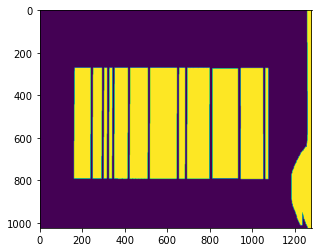

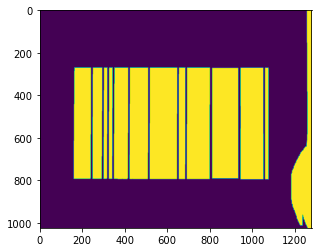

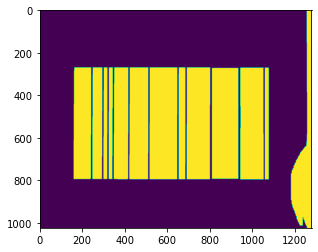

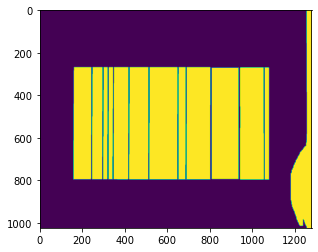

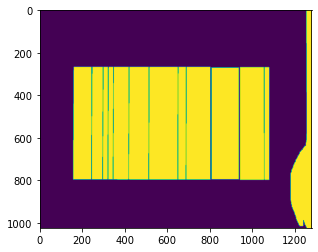

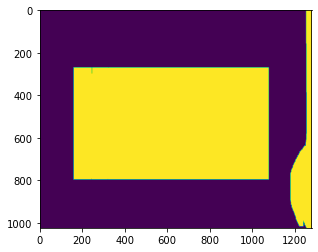

In [10]:
dilated = apply_dilation(opened)

In [173]:
abs(202930020-204000000)

1069980

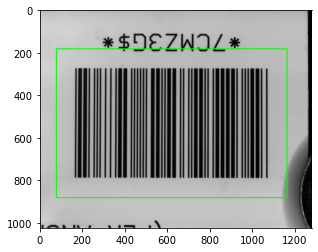

In [28]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

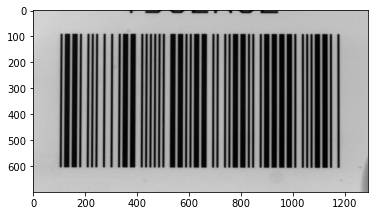

In [30]:
h = 1024
w = 1280

coordinates_source = box.astype('float32')

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))
destination_height = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
coordinates_destination = np.array([[0, destination_height-1],
                                    [0, 0], 
                                    [destination_width-1, 0],
                                    [destination_width-1, destination_height-1]], dtype='float32')

# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')